# Задача 5. Обучение без учителя

## Задача

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## Датасет

Распознавание чисел на изображениях 28x28 пикселей: https://www.kaggle.com/competitions/digit-recognizer/data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("train.csv", dtype=np.uint8)
X = df.loc[:, df.columns != "label"]
y = df["label"]
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Количество объектов для каждого числа примерно одинаковое.

In [4]:
print(f"median:             {y.value_counts().median()}")
print(f"standard deviation: {y.value_counts().std()}")

median:             4157.0
standard deviation: 237.08929400825616


## EDA

Как можно заметить, большое количество пикселей по краям никогда не используются, от них можно избавиться.

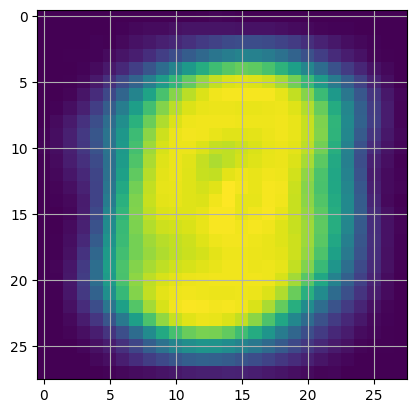

In [5]:
plt.imshow(X.std().values.reshape([28, 28]))
plt.grid(None)

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [7]:
def plot_2d_projection(X, title):
    plt.figure(figsize=(12, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.get_cmap("nipy_spectral", 10), edgecolors="none", alpha=0.4)
    plt.colorbar()
    plt.title(title)
    plt.grid(None)

### PCA

In [8]:
%%time
pca = PCA()
X_pca = pca.fit_transform(X)

CPU times: user 13.3 s, sys: 3.78 s, total: 17.1 s
Wall time: 19.9 s


<ipython-input-7-2c656b5b12ca>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.get_cmap("nipy_spectral", 10), edgecolors="none", alpha=0.4)


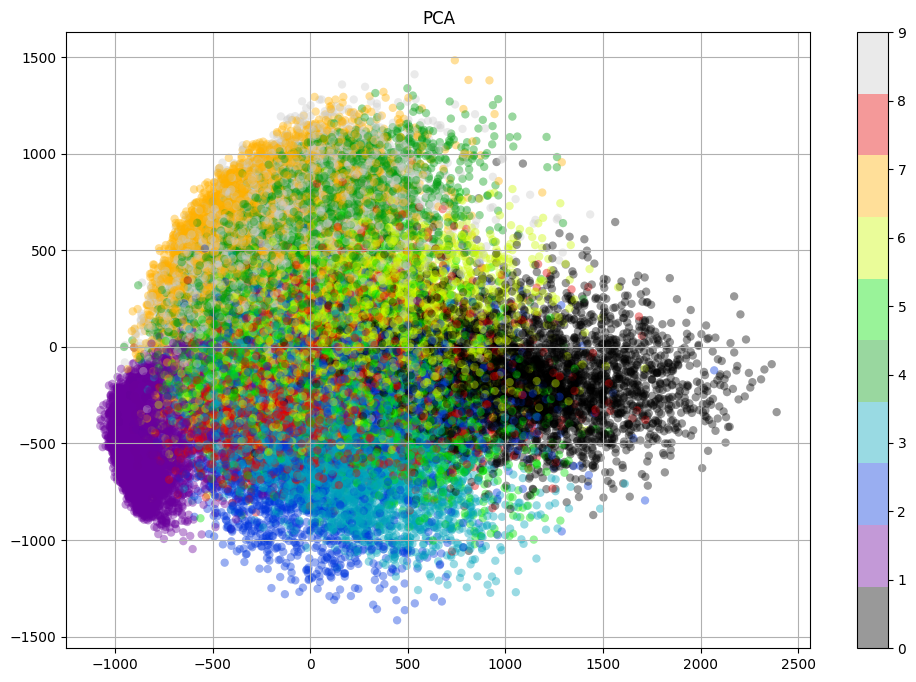

In [9]:
plot_2d_projection(X_pca, "PCA")

### t-SNE

In [10]:
%%time
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

CPU times: user 20min 5s, sys: 3.31 s, total: 20min 8s
Wall time: 13min 8s


<ipython-input-7-2c656b5b12ca>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.get_cmap("nipy_spectral", 10), edgecolors="none", alpha=0.4)


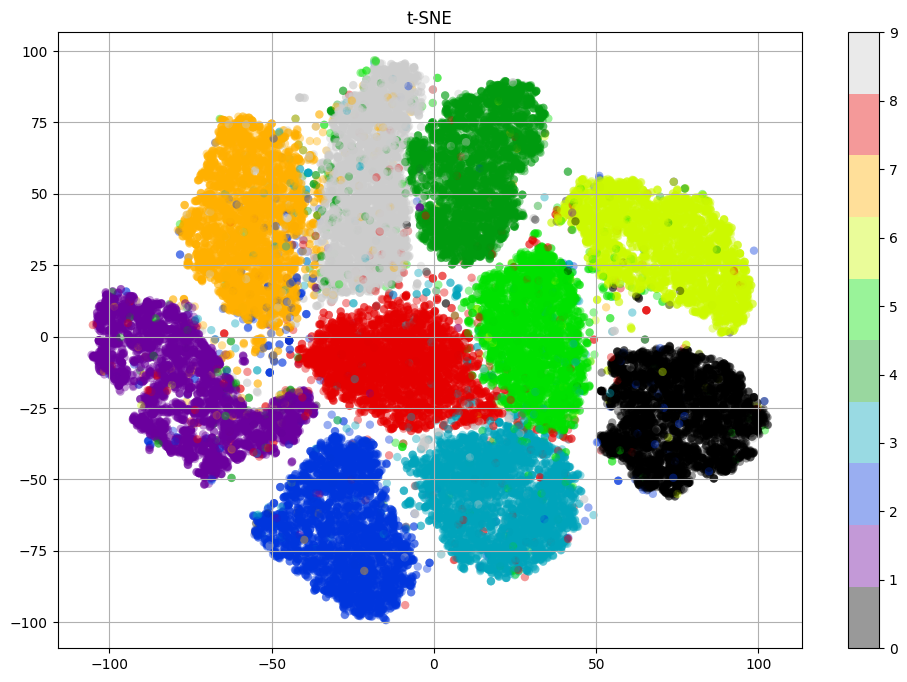

In [11]:
plot_2d_projection(X_tsne, "t-SNE")

Как видно из графиков, PCA способен разделить объекты на едва заметные группы. Алгоритм t-SNE же работает с этими данными значительно лучше. Однако всвязи с тем, что t-SNE в десятки раз медленней, далее для уменьшения размерности датасета будем использовать алгоритм PCA.

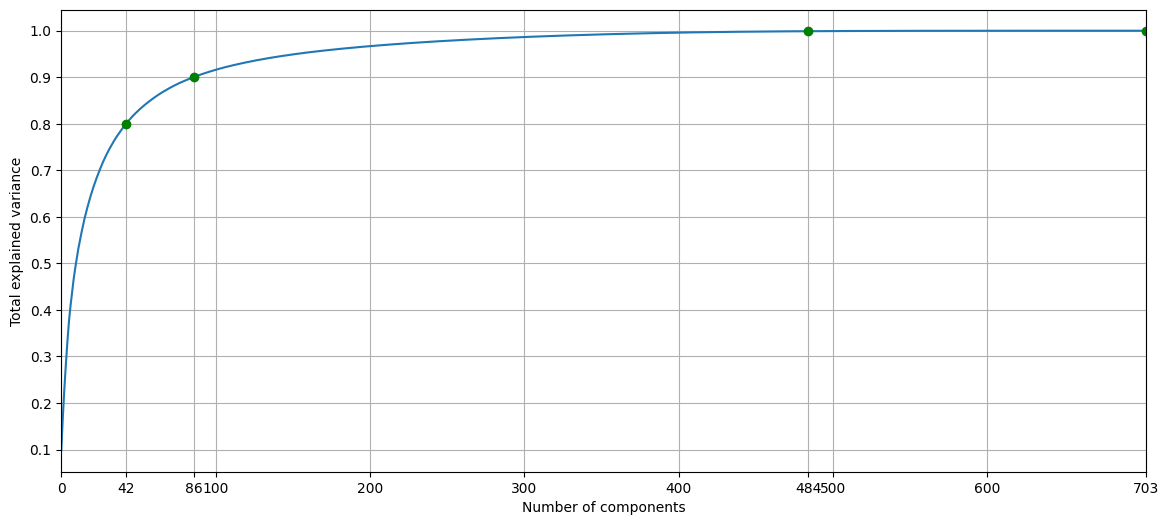

In [12]:
plt.figure(figsize=(14, 6))

variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(variance_ratio)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(0, 512)

y_pos = [0.8, 0.9, 0.999, 1.0]
x_pos = [(np.abs(variance_ratio - y_val)).argmin() for y_val in y_pos]

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(list(plt.xticks()[0]) + x_pos)
plt.grid(True)

plt.plot(x_pos, y_pos, "o", color="g")

Как видно из графика, 703 пикселя описывают 100\% дисперсии. При этом в два раза меньшее количество пикселей (примерно 400) описывают около 99.9%.

А так же, 42 пикселя описывают 80\% дисперсии, 86 пикселя - 90\%.

Можно значительно снизить размерность датасета.

## Реализация K-means

In [13]:
import numpy as np
import numpy.typing as npt
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator


class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=8, *, tol=0.001, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def _get_labels(self, X):
        dists_to_centers = np.linalg.norm(
            X[..., None] - self.cluster_centers_.T, axis=1
        )
        return np.argmin(dists_to_centers, axis=1)

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)

        self.n_features_in_ = X.shape[1]

        self.cluster_centers_ = X[
            self.random_state_.choice(len(X), size=self.n_clusters, replace=False)
        ]

        m_shift = np.inf
        while m_shift > self.tol:
            self.labels_ = self._get_labels(X)
            new_c = np.empty((self.n_clusters, self.n_features_in_))
            for i in range(self.n_clusters):
                new_c[i] = np.mean(X[self.labels_ == i], axis=0)
            m_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_c, axis=1))
            self.cluster_centers_ = new_c

        return self

    def predict(self, X):
        check_is_fitted(self)
        return self._get_labels(check_array(X))


check_estimator(MyKMeans())


## Обучение

Модели будут обучаться на датасетах:
- полный датасет размерности 784 
- датасет с размернстью 703, сжатый PCA - покрытие дисперсии 100%
- датасет с размернстью 484, сжатый PCA - покрытие дисперсии 99.9%
- датасет с размернстью 86, сжатый PCA - покрытие дисперсии 90%
- датасет с размернстью 42, сжатый PCA - покрытие дисперсии 80%

In [14]:
X_red = [PCA(n_components=i).fit_transform(X) for i in x_pos]
X_red.append(X.to_numpy(dtype=np.float64))

In [15]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score,
)

In [16]:
RESULTS_PATH = pathlib.Path("cv_results.csv")


def train_and_store(estimator, param_grid={}, results_path=RESULTS_PATH):
    param_combs = [
        dict(params)
        for params in itertools.product(
            *([(n, v) for v in vs] for (n, vs) in param_grid.items())
        )
    ]

    results = []
    for X in X_red:
        best_ari = None
        best_ami = None
        best_fmi = None

        for params in param_combs:
            cloned_estimator = clone(estimator).set_params(**params)

            start_t = time.perf_counter()
            pred = cloned_estimator.fit_predict(X)
            fit_time = time.perf_counter() - start_t

            ari = adjusted_rand_score(y, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_time, params

            ami = adjusted_mutual_info_score(y, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_time, params

            fmi = fowlkes_mallows_score(y, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_time, params

        print(
            f"Best params for {X.shape[1]}:",
            f"ARI: {best_ari[2]}",
            f"AMI: {best_ami[2]}",
            f"FMI: {best_fmi[2]}",
            sep="\n",
        )

        results.append(
            {
                "Clusterer": estimator.__class__.__name__,
                "Input dimension": X.shape[1],
                "Fit time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
                "ARI": best_ari[0],
                "AMI": best_ami[0],
                "FMI": best_fmi[0],
            }
        )

    pd.DataFrame(results).to_csv(
        results_path, mode="a", header=not results_path.exists()
    )


## Тесты

### MyKMeans

In [17]:
%%time

train_and_store(MyKMeans(n_clusters=10, random_state=0))

Best params for 42:
ARI: {}
AMI: {}
FMI: {}
Best params for 86:
ARI: {}
AMI: {}
FMI: {}
Best params for 484:
ARI: {}
AMI: {}
FMI: {}
Best params for 703:
ARI: {}
AMI: {}
FMI: {}
Best params for 784:
ARI: {}
AMI: {}
FMI: {}
CPU times: user 3min 9s, sys: 2min 41s, total: 5min 51s
Wall time: 6min 12s


### Sklearn KMeans

In [18]:
from sklearn.cluster import KMeans

In [19]:
%%time

train_and_store(
    KMeans(n_clusters=10, n_init="auto", random_state=0),
    param_grid={"algorithm": ["lloyd", "elkan"]},
)

Best params for 42:
ARI: {'algorithm': 'lloyd'}
AMI: {'algorithm': 'lloyd'}
FMI: {'algorithm': 'lloyd'}
Best params for 86:
ARI: {'algorithm': 'lloyd'}
AMI: {'algorithm': 'lloyd'}
FMI: {'algorithm': 'lloyd'}
Best params for 484:
ARI: {'algorithm': 'lloyd'}
AMI: {'algorithm': 'lloyd'}
FMI: {'algorithm': 'lloyd'}
Best params for 703:
ARI: {'algorithm': 'lloyd'}
AMI: {'algorithm': 'lloyd'}
FMI: {'algorithm': 'lloyd'}
Best params for 784:
ARI: {'algorithm': 'lloyd'}
AMI: {'algorithm': 'lloyd'}
FMI: {'algorithm': 'lloyd'}
CPU times: user 43.7 s, sys: 1.52 s, total: 45.2 s
Wall time: 28.2 s


### Sklearn DBSCAN

In [20]:
from sklearn.cluster import DBSCAN

In [21]:
%%time

train_and_store(
    DBSCAN(n_jobs=-1),
    param_grid={
        "eps": [750, 1000, 1500],
        "min_samples": [20, 100, 150],
    }
)

Best params for 42:
ARI: {'eps': 1000, 'min_samples': 100}
AMI: {'eps': 750, 'min_samples': 100}
FMI: {'eps': 750, 'min_samples': 150}
Best params for 86:
ARI: {'eps': 1000, 'min_samples': 20}
AMI: {'eps': 1000, 'min_samples': 150}
FMI: {'eps': 750, 'min_samples': 100}
Best params for 484:
ARI: {'eps': 1500, 'min_samples': 150}
AMI: {'eps': 1000, 'min_samples': 100}
FMI: {'eps': 1000, 'min_samples': 100}
Best params for 703:
ARI: {'eps': 1500, 'min_samples': 150}
AMI: {'eps': 1000, 'min_samples': 100}
FMI: {'eps': 1000, 'min_samples': 100}
Best params for 784:
ARI: {'eps': 1500, 'min_samples': 150}
AMI: {'eps': 1000, 'min_samples': 100}
FMI: {'eps': 1000, 'min_samples': 100}


## Результаты

In [22]:
results_amalgamated = pd.read_csv(RESULTS_PATH)

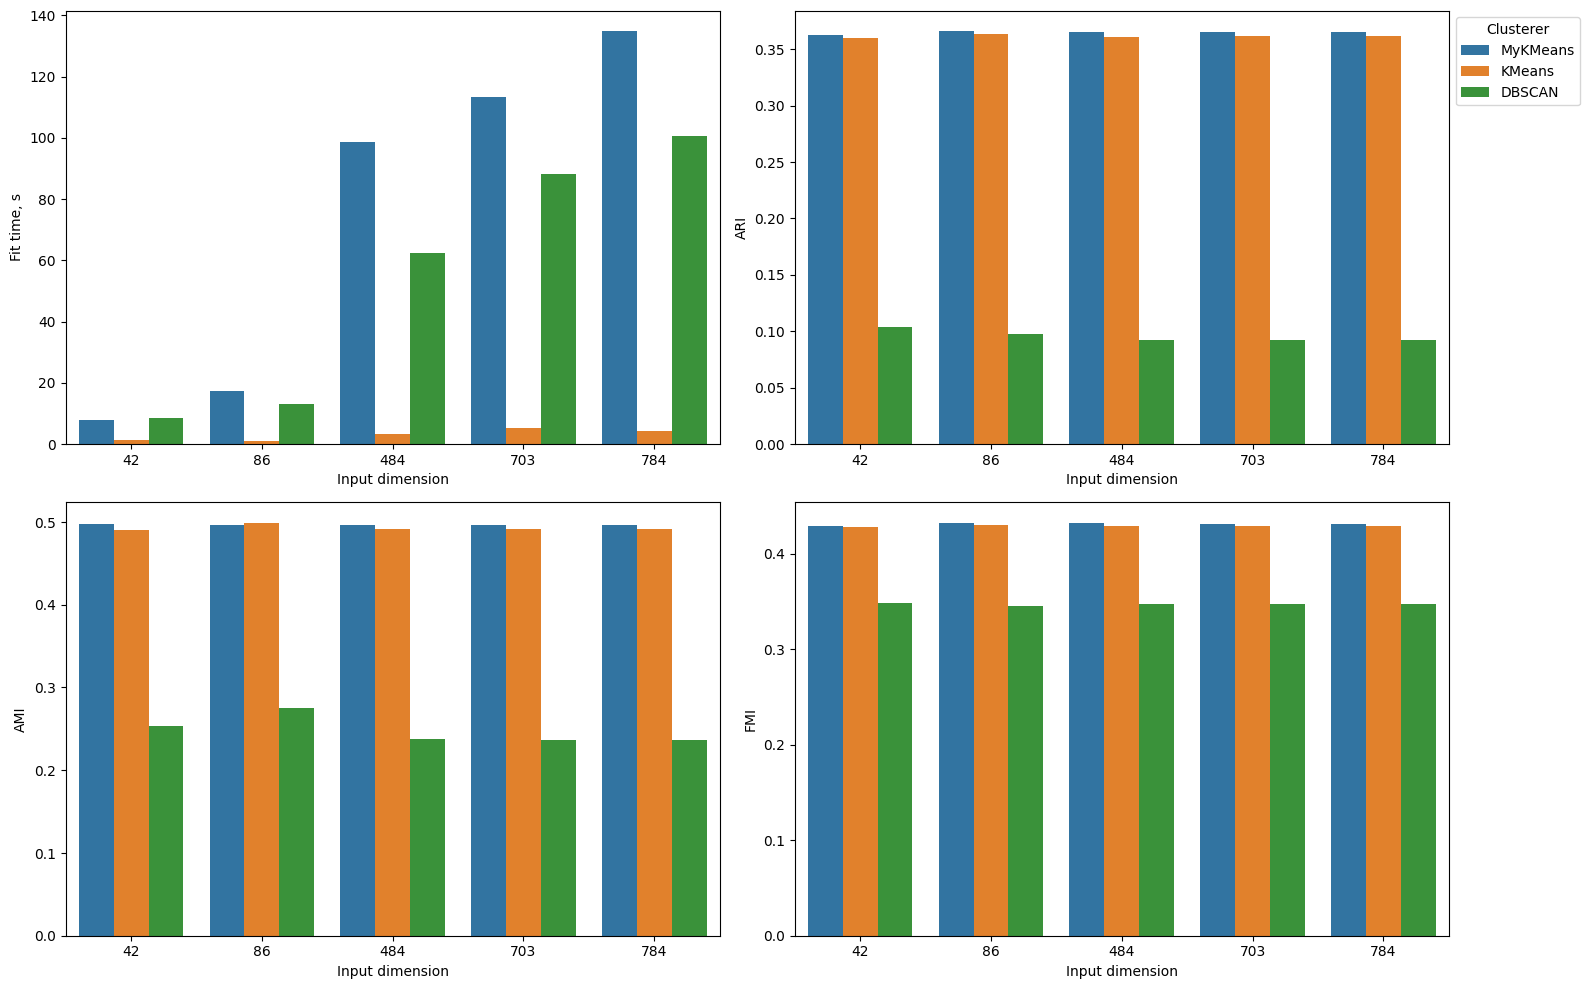

In [24]:
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))

for metric, ax in zip(["Fit time, s", "ARI", "AMI", "FMI"], axs.flatten()):
    sns.barplot(pd.read_csv(RESULTS_PATH), x="Input dimension", y=metric, hue="Clusterer", ax=ax)
    if metric == "ARI":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

fig.tight_layout()

## Выводы

На графиках видно, что уменьшение размерности данных при помощи PCA очень слабо повлияло на точность кластеризации, при этом сильно уменьшив время на обучение.

Так же можно заметить, что DBSCAN проигрывает алгоритму KMeans по точности, а так же по скорости обучения реализации sklearn.

Все алгоритмы показали не очень высокую точность на данном датасете.

Данная задача является достаточно удачным примером того, что грамотный EDA анализ позволяет существенно улучшить качетсво работы с данными.